In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.applications import ResNet50, VGG16
import keras_tuner as kt
# import torch
# import torchvision
# import torchvision.transforms as transforms

In [2]:
dinosaur = pd.read_csv("data/dinosaur.csv")

dinosaur.head()

,Name,Period,Diet,Country
0,Aardonyx,Jurassic,herbivore,South Africa
1,Abelisaurus,Cretaceous,carnivore,South America
2,Abrictosaurus,Jurassic,herbivore,South Africa
3,Abrosaurus,Jurassic,herbivore,China
4,Abydosaurus,Cretaceous,herbivore,North America


In [3]:
r = requests.get("https://dinosaur-facts-api.shultzlab.com/dinosaurs")
rr = r.json()

rr

[{'Name': 'Aardonyx',
  'Description': 'An early stage in the evolution of sauropods.'},
 {'Name': 'Abelisaurus',
  'Description': '"Abel\'s lizard" has been reconstructed from a single skull.'},
 {'Name': 'Abrictosaurus',
  'Description': 'An early relative of Heterodontosaurus.'},
 {'Name': 'Abrosaurus',
  'Description': 'A close Asian relative of Camarasaurus.'},
 {'Name': 'Abydosaurus',
  'Description': "This sauropod's intact skull was discovered in 2010."},
 {'Name': 'Acanthopholis', 'Description': "No, it's not a city in Greece."},
 {'Name': 'Achelousaurus',
  'Description': 'Might this have been a growth stage of Pachyrhinosaurus?'},
 {'Name': 'Achillobator',
  'Description': 'This fierce raptor was discovered in modern-day Mongolia.'},
 {'Name': 'Acristavus',
  'Description': 'This early hadrosaur lacked any ornamentation on its skull.'},
 {'Name': 'Acrocanthosaurus',
  'Description': 'The largest meat-eating dinosaur of the early Cretaceous period.'},
 {'Name': 'Acrotholus',


In [4]:
!tree

Folder PATH listing for volume Windows
Volume serial number is 2AF4-788F
C:.
+---.conda
�   +---conda-meta
�   +---DLLs
�   +---etc
�   +---include
�   �   +---cpython
�   �   +---internal
�   +---Lib
�   �   +---asyncio
�   �   �   +---__pycache__
�   �   +---collections
�   �   �   +---__pycache__
�   �   +---concurrent
�   �   �   +---futures
�   �   �   �   +---__pycache__
�   �   �   +---__pycache__
�   �   +---ctypes
�   �   �   +---macholib
�   �   �   �   +---__pycache__
�   �   �   +---__pycache__
�   �   +---curses
�   �   �   +---__pycache__
�   �   +---dbm
�   �   �   +---__pycache__
�   �   +---email
�   �   �   +---mime
�   �   �   �   +---__pycache__
�   �   �   +---__pycache__
�   �   +---encodings
�   �   �   +---__pycache__
�   �   +---ensurepip
�   �   �   +---_bundled
�   �   �   +---__pycache__
�   �   +---html
�   �   �   +---__pycache__
�   �   +---http
�   �   �   +---__pycache__
�   �   +---idlelib
�   �   �   +---Icons
�   �   �   +---idle_test
�   �   �   �  

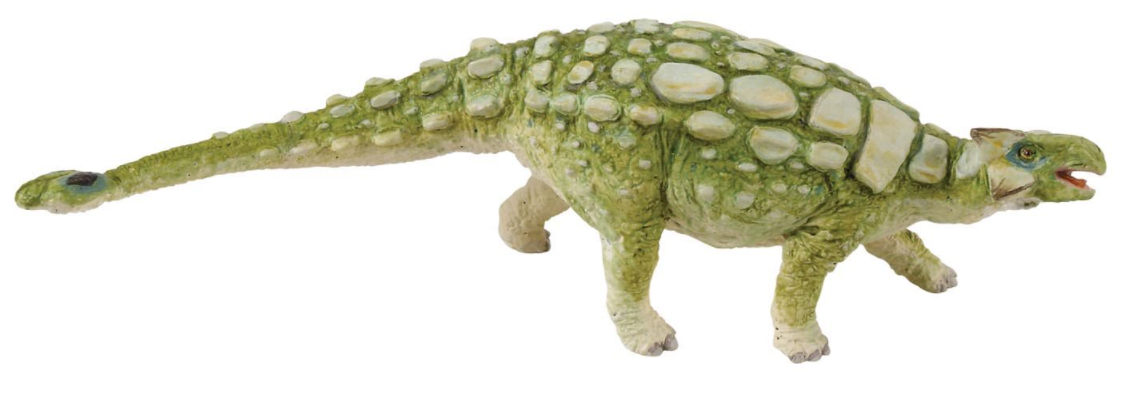

In [5]:
PIL.Image.open("data/ankylosaurus/1.png")

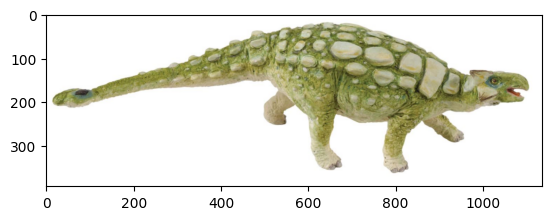

In [6]:
plt.imshow(PIL.Image.open("data/ankylosaurus/1.png"))

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'og_data',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(300, 500))

val_ds = tf.keras.utils.image_dataset_from_directory(
  'og_data',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(300, 500))


Found 200 files belonging to 5 classes.
Using 160 files for training.
Found 200 files belonging to 5 classes.
Using 40 files for validation.


In [8]:
train_df = tf.keras.utils.image_dataset_from_directory(
    "output/train",
    image_size = (300, 500)
)

test_df = tf.keras.utils.image_dataset_from_directory(
    "output/test",
    image_size = (300, 500)
)
val_df = tf.keras.utils.image_dataset_from_directory(
    "output/val",
    image_size = (300, 500)
)

Found 160 files belonging to 5 classes.
Found 20 files belonging to 5 classes.
Found 20 files belonging to 5 classes.


In [9]:

for images, labels in train_ds.take(1):
  print(labels)

tf.Tensor([4 3 3 4 0 2 0 2 2 0 2 4 1 4 3 3 0 2 3 2 1 4 4 4 4 1 1 0 3 3 1 0], shape=(32,), dtype=int32)


In [10]:
class_names = train_ds.class_names
class_names


['ankylosaurus', 'brontosaurus', 'pterodactyl', 'trex', 'triceratops']

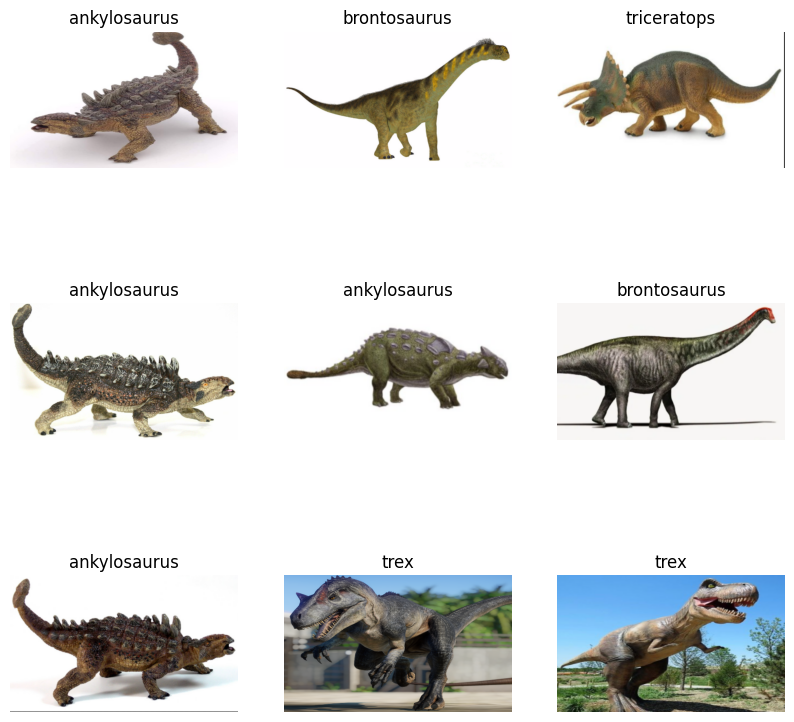

In [11]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(300,
                                  500,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

C:\Users\kjhoa\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
def build_model(hp):
    model = Sequential([
        data_augmentation,
        layers.Rescaling(1./255, input_shape = (300, 500, 3)),
        layers.Conv2D(
            filters = hp.Int('layer1_filter', min_value = 16, max_value = 128, step = 16),
            kernel_size = hp.Choice('layer1_kernel', values = [3, 5, 7]),
            padding = 'same',
            input_shape = (300, 500, 3)
        ),
        layers.Activation('relu'),
        layers.Dropout(0,2),
        layers.MaxPooling2D(),
        layers.Conv2D(
            filters = hp.Int('layer1_filter', min_value = 16, max_value = 128, step = 16),
            kernel_size = hp.Choice('layer1_kernel', values = [3, 5, 7]),
            activation = 'relu',
            padding = 'same'
        ),
        layers.Dropout(0,2),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(
            hp.Int('dense_layer1', min_value = 16, max_value = 128, step = 16),
            activation = 'relu'
        ),
        layers.Dense(5, activation = 'softmax')
    ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [25]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)

In [26]:
tuner = kt.Hyperband(build_model,
objective = 'val_accuracy',
max_epochs = 10,
factor = 3,
directory = 'dir',
project_name = 'dinosaur')

Reloading Tuner from dir\dinosaur\tuner0.json


In [27]:
tuner.search(train_ds, validation_data = val_ds, epochs = 15, callbacks = [stop_early])

In [28]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

best_hps

In [29]:
model = tuner.get_best_models(num_models = 1)[0]
model.fit(train_ds,
validation_data = val_ds,
epochs = 20)

Epoch 1/20


C:\Users\kjhoa\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.6336 - loss: 2.1522 - val_accuracy: 0.6250 - val_loss: 0.8457
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.6925 - loss: 0.8136 - val_accuracy: 0.6500 - val_loss: 1.0890
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7278 - loss: 0.6983 - val_accuracy: 0.7000 - val_loss: 0.6043
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.7663 - loss: 0.5559 - val_accuracy: 0.7500 - val_loss: 0.7193
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.8072 - loss: 0.5076 - val_accuracy: 0.6750 - val_loss: 0.7668
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.7872 - loss: 0.4685 - val_accuracy: 0.7250 - val_loss: 0.8277
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.8337 - loss: 0.4600 - val_accuracy: 0.7500 - val_loss: 0.5416
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8068 - loss: 0.5642 - val_accuracy: 0.6250 - val_loss: 1.2292
Epoch 9/20
5/5 ━━━━

In [30]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(300, 500, 3)),
    layers.Conv2D(16, 3, padding='same', input_shape = (300, 500, 3)),
    layers.Activation('relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D(),
    # layers.Conv2D(64, 3, padding='same', activation='relu'),
    # layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.fit(train_ds,
validation_data = val_ds,
epochs = 20)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8552 - loss: 0.3724 - val_accuracy: 0.7000 - val_loss: 0.7743
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8552 - loss: 0.3990 - val_accuracy: 0.9000 - val_loss: 0.4128
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8785 - loss: 0.3791 - val_accuracy: 0.6500 - val_loss: 0.6260
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8523 - loss: 0.3958 - val_accuracy: 0.8500 - val_loss: 0.6590
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8842 - loss: 0.3394 - val_accuracy: 0.7750 - val_loss: 0.4271
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9255 - loss: 0.2420 - val_accuracy: 0.8750 - val_loss: 0.4351
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9187 - loss: 0.2278 - val_accuracy: 0.9000 - val_loss: 0.5489
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9295 - loss: 0.2400 - val_accuracy: 0.7250 - val_loss: 0.5827
Epoch 9/

In [16]:
resnet_model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape = (300, 500, 3)),
    ResNet50(include_top = True, weights = None, input_shape = (300, 500, 3), pooling = "max", classes = num_classes, classifier_activation = "softmax"),
    layers.Dense(num_classes, activation='relu')
])
resnet_model.layers[0].trainable = False
resnet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
resnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ ?                      │    23,597,957 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
base_model = VGG16(include_top = False, weights = "imagenet", input_shape = (300, 500, 3))
base_model.trainable = False

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 300, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 500, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 500, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 250, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 250, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 250, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 125, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 125, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 125, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 125, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 62, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 62, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 62, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 15, 512)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
inputs = tf.keras.Input(shape = (300, 500, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation = "softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-5),
              metrics = ["accuracy"])

In [24]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 300, 500,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 300, 500)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 300, 500)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 300, 500)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 300, 500,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 300, 500,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 9, 15,     │ 14,714,688 │ add_2[0][0]       │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 69120)     │          0 │ vgg16[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │  8,847,488 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 5)         │        645 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,562,821 (89.89 MB)

 Trainable params: 15,927,557 (60.76 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [25]:
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 300, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 500, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 500, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 250, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 250, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 250, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 125, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 125, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 125, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 125, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 62, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 62, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 62, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 15, 512)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [26]:
model.fit(train_df, validation_data = val_df, epochs = 15)

Epoch 1/15


C:\Users\kjhoa\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5/5 ━━━━━━━━━━━━━━━━━━━━ 114s 23s/step - accuracy: 0.4140 - loss: 12.4283 - val_accuracy: 0.6500 - val_loss: 3.2005
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 141s 28s/step - accuracy: 0.8958 - loss: 1.0593 - val_accuracy: 0.9000 - val_loss: 1.0816
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 131s 27s/step - accuracy: 0.9654 - loss: 0.1342 - val_accuracy: 0.8000 - val_loss: 1.7347
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 120s 25s/step - accuracy: 0.9595 - loss: 0.2308 - val_accuracy: 0.8000 - val_loss: 1.0995
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 116s 24s/step - accuracy: 0.9720 - loss: 0.2705 - val_accuracy: 0.8500 - val_loss: 1.1173
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 114s 23s/step - accuracy: 0.9958 - loss: 0.0257 - val_accuracy: 0.8500 - val_loss: 1.4646
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 105s 21s/step - accuracy: 0.9871 - loss: 0.0442 - val_accuracy: 0.9500 - val_loss: 1.0550
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 104s 21s/step - accuracy: 1.0000 - loss: 1.0946e-04 - val_accuracy: 0.9500 - val_loss: 1.055

In [19]:
vgg_model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape = (300, 500, 3)),
    VGG16(include_top = False, weights = 'imagenet', input_shape = (300, 500, 3), pooling = "max", classes = num_classes, classifier_activation = "softmax"),
    layers.Dense(num_classes, activation='relu')
])
vgg_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

C:\Users\kjhoa\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [20]:
vgg_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 300, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
training = vgg_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10
)

Epoch 1/10


C:\Users\kjhoa\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


5/5 ━━━━━━━━━━━━━━━━━━━━ 126s 26s/step - accuracy: 0.2183 - loss: 1.9637 - val_accuracy: 0.1250 - val_loss: 2.0320
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 127s 26s/step - accuracy: 0.2474 - loss: 1.9357 - val_accuracy: 0.1250 - val_loss: 2.3574
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 119s 24s/step - accuracy: 0.2543 - loss: 1.8698 - val_accuracy: 0.1250 - val_loss: 2.0632
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 100s 20s/step - accuracy: 0.2079 - loss: 1.9939 - val_accuracy: 0.1250 - val_loss: 2.2840
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 97s 20s/step - accuracy: 0.2552 - loss: 1.9107 - val_accuracy: 0.1250 - val_loss: 2.0522
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 142s 30s/step - accuracy: 0.2222 - loss: 1.9515 - val_accuracy: 0.1250 - val_loss: 2.4211
Epoch 7/10
2/5 ━━━━━━━━━━━━━━━━━━━━ 1:09 23s/step - accuracy: 0.2188 - loss: 1.9755

KeyboardInterrupt: 

In [15]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(300, 500, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.1959 - loss: 14.2930 - val_accuracy: 0.1250 - val_loss: 5.1087
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.1685 - loss: 2.7807 - val_accuracy: 0.2000 - val_loss: 1.5811
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3043 - loss: 1.5386 - val_accuracy: 0.3750 - val_loss: 1.5661
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5398 - loss: 1.3413 - val_accuracy: 0.5000 - val_loss: 1.3151
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6556 - loss: 1.0488 - val_accuracy: 0.5000 - val_loss: 1.2072
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6227 - loss: 1.0152 - val_accuracy: 0.5750 - val_loss: 0.9597
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7152 - loss: 0.7779 - val_accuracy: 0.5250 - val_loss: 0.8630
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6744 - loss: 0.6832 - val_accuracy: 0.5500 - val_loss: 0.7679
Epoch 9/15
5

In [34]:
history = model.fit(
  train_df,
  validation_data=val_df,
  epochs=15
)


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8628 - loss: 0.4224 - val_accuracy: 0.7000 - val_loss: 0.5474
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8332 - loss: 0.4102 - val_accuracy: 0.8500 - val_loss: 0.3347
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9166 - loss: 0.3299 - val_accuracy: 0.8500 - val_loss: 0.3427
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8777 - loss: 0.3156 - val_accuracy: 0.8000 - val_loss: 0.3835
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9335 - loss: 0.2869 - val_accuracy: 0.9000 - val_loss: 0.2630
Epoch 6/15
3/5 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9740 - loss: 0.1829

In [23]:
model.evaluate(test_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9000 - loss: 0.3150


[0.3149840831756592, 0.8999999761581421]

In [46]:

img = tf.keras.utils.load_img(
    'anktest.jpeg', target_size=(300, 500)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
This image most likely belongs to Pachycephalosaurus with a 47.80 percent confidence.


In [28]:
acc


[0.21875,
 0.23749999701976776,
 0.2562499940395355,
 0.3499999940395355,
 0.543749988079071,
 0.5874999761581421,
 0.7250000238418579,
 0.6187499761581421,
 0.6625000238418579,
 0.675000011920929,
 0.75,
 0.7875000238418579,
 0.800000011920929,
 0.793749988079071,
 0.8374999761581421]

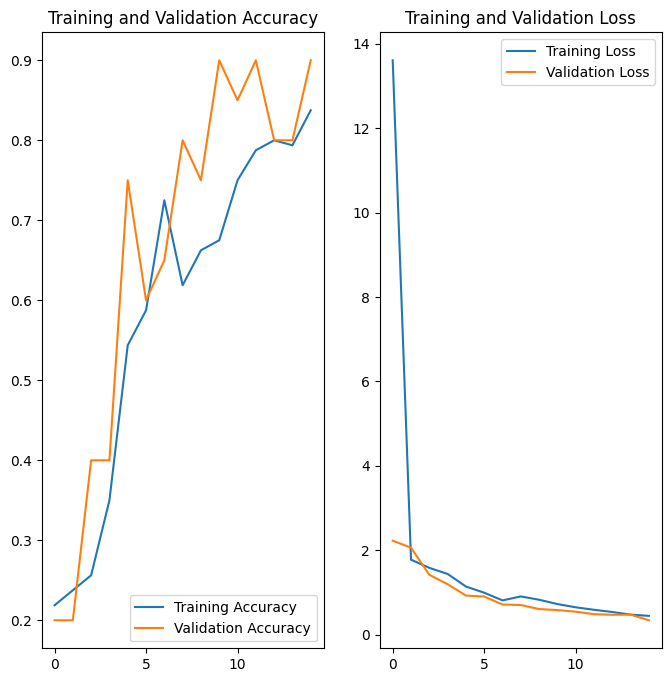

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()